#### Importing required pySpark libraries, Configuring Spark and Spark context

In [1]:
import findspark
findspark.init()
import pyspark
conf = pyspark.SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '10G')
        .set('spark.driver.maxResultSize', '10G'))
sc = pyspark.SparkContext(conf=conf)
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
sqlc = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

#### Reading data

In [2]:
data = spark.read.format("csv").option("header","true").load("file:///home/vyom/UGA/FraudDetection/creditcard.csv")

#### Checking class frequency

In [3]:
classFreq = data.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    0|284315|
|    1|   492|
+-----+------+



In [4]:
import pandas as pd

In [5]:
toPlot = classFreq.toPandas()

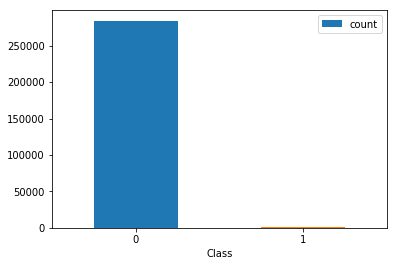

In [36]:
toPlot.plot.bar(x='Class', y='count',rot=0)

#### Converting String data type of column  to double

In [7]:
for column in data.columns:
    data = data.withColumn(column,data[column].cast("double"))

#### Adding index to keep track of the rows even after shuffling

In [8]:
from pyspark.sql.window import Window
win = Window().orderBy('Time')
data = data.withColumn("idx", row_number().over(win))

#### Importing required Spark ML lib methods

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

#### Converting the feature columns to dense vector (required by spark) and  creating label and index columns

In [10]:
training_df = data.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31]))

In [11]:
training_df = spark.createDataFrame(training_df,["features","label","index"])

In [12]:
training_df = training_df.select("index","features","label")

#### Splitting data into training and testing data

In [13]:
train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

In [14]:
train_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|227418|
|  1.0|   376|
+-----+------+



In [15]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|56897|
|  1.0|  116|
+-----+-----+



#### Creating Gradient Boosting Trees Classifier Model to fit and predict data

In [16]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)

In [17]:
model = gbt.fit(train_data)

In [18]:
predictions = model.transform(test_data)

#### Checking the count of records classified into each classes

In [19]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|56913|
|       1.0|  100|
+----------+-----+



#### Calculating accuracy of model - This can be misleading due to class imbalance

In [20]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9882687287914512

#### Calculating percentage of fraud records predicted correctly

In [21]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [22]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   96|
|              0|56917|
+---------------+-----+



In [23]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|56897|
|  1.0|  116|
+-----+-----+



#### Number of fraud records identified = 96
#### Number of Total fraud records in test dataset = 116
#### Percentage of fraud records identified correctly (Accuracy to identify fraud) = (96/116)*100 = 82.76%

In [24]:
from pyspark.sql.functions import col

In [25]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

In [26]:
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]

In [27]:
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

In [28]:
FraudPredictionAccuracy

82.75862068965517

#### Calculating Confusion matrix

In [29]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

In [30]:
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

In [31]:
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

In [32]:
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [33]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

True Positive:  96 
True Negative:  56893 
False Positive:  4 
False Negative:  20


### Recall

In [34]:
print("Recall: ",tp/(tp+fn))

Recall:  0.8275862068965517


### Precision

In [35]:
print("Precision: ", tp/(tp+fp))

Precision:  0.96
